# Gibbs energy analysis of $Si_3N_4$ and $MnSiN_2$

Data was retrieved and manually prepared from extractions made from [NIST JANAF tables](https://janaf.nist.gov/).

In [1]:
%matplotlib inline
%config InlineBackend.figure_formats = ["svg"]

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

## Data treatment

Because of different conventions of reference state, it can be tricky to figure how to use JANAF data to check CALPHAD parameters. Below we make a try to find the required transformations. External data for $Si_3N_4$ comes from [Ma (2005)](https://doi.org/10.1016/j.calphad.2003.12.005).

In [3]:
def get_hser(db, Tr=298.15):
    """ Get formation enthalpy at reference temperature. """
    return float(1000*db.loc[db["T(K)"] == Tr]["delta-f H"])


def load_fix_janaf_for_calphad(fname):
    """ Load file and make transformations. """
    db = pd.read_csv(fname, sep=",")

    # Some missing data on top of some files, fill with zero.
    db.fillna(0.0, inplace=True)

    # In JANAF the reference enthalpy is 298.15K, while for CALPHAD
    # we must use 0K to retrieve a non-zero enthalpy at 298.15K.
    # Below we perform this shift to ensure compliance.
    db["H"] = 1000*(db["H-H(Tr)"] - db["H-H(Tr)"].iloc[0])

    # To get GHSER as in CALPHAD we add a column as below. Notice
    # that because of JANAF definition of H(Tr) we need to add the
    # formation enthalpy to get the CALPHAD compatible value.
    db["GHSER"] = -1*db["-[G-H(Tr)]/T"]*db["T(K)"]
    db["GHSER"] += get_hser(db)

    # Get data in range 298-2000K only for what comes next.
    db = db.loc[(db["T(K)"] > 298) & (db["T(K)"] < 2000)]

    return pd.DataFrame(db)

Next we proceed with loading and inspecting the head of JANAF tables.

In [4]:
tab_nn2si0 = load_fix_janaf_for_calphad("janaf/n2.tab")
tab_nn2si0.head()

,T(K),Cp,S,-[G-H(Tr)]/T,H-H(Tr),delta-f H,delta-f G,log Kf,H,GHSER
3,298.15,29.124,191.609,191.609,0.000,0.0,0.0,0.0,8670.0,-57128.22335
4,300.00,29.125,191.789,191.610,0.054,0.0,0.0,0.0,8724.0,-57483.00000
5,400.00,29.249,200.181,192.753,2.971,0.0,0.0,0.0,11641.0,-77101.20000
6,500.00,29.580,206.739,194.917,5.911,0.0,0.0,0.0,14581.0,-97458.50000
7,600.00,30.110,212.176,197.353,8.894,0.0,0.0,0.0,17564.0,-118411.80000


In [5]:
tab_nn0si1 = load_fix_janaf_for_calphad("janaf/si1.tab")
tab_nn0si1.head()

,T(K),Cp,S,-[G-H(Tr)]/T,H-H(Tr),delta-f H,delta-f G,log Kf,H,GHSER
3,298.15,20.000,18.820,18.820,0.000,0.0,0.0,0.0,3218.0,-5611.183
4,300.00,20.050,18.943,18.820,0.037,0.0,0.0,0.0,3255.0,-5646.000
5,400.00,22.142,25.032,19.636,2.159,0.0,0.0,0.0,5377.0,-7854.400
6,500.00,23.330,30.110,21.237,4.436,0.0,0.0,0.0,7654.0,-10618.500
7,600.00,24.154,34.440,23.086,6.812,0.0,0.0,0.0,10030.0,-13851.600


In [6]:
tab_nn4si3 = load_fix_janaf_for_calphad("janaf/si3n4.tab")
tab_nn4si3.head()

,T(K),Cp,S,-[G-H(Tr)]/T,H-H(Tr),delta-f H,delta-f G,log Kf,H,GHSER
3,298.15,99.533,112.967,112.967,0.000,-744.752,-647.343,113.412,0.0,-778433.11105
4,300.00,99.788,113.583,112.969,0.184,-744.787,-646.739,112.607,184.0,-778642.70000
5,400.00,110.667,143.790,117.014,10.711,-746.459,-613.792,80.153,10711.0,-791557.60000
6,500.00,120.708,169.582,125.007,22.288,-747.595,-580.482,60.643,22288.0,-807255.50000
7,600.00,129.704,192.417,134.374,34.826,-748.151,-546.998,47.620,34826.0,-825376.40000


The value of $G-H(SER)$ has been fixed in JANAF data and must now be compatible with the polynomial by Ma (2003).

Because Ma (2003) reports Gibbs energy per mole of atoms and not per CEF unit formula, we divide the values by 7 (3 Si + 4 N).

In [7]:
T = np.linspace(300, 1600, 1000)

T_1 = T
T_2 = tab_nn4si3["T(K)"]

GSI3N4_1 = -788513.009+733.225*T-121.79*T*np.log(T)\
    -0.02065*T**2+1666886.4*T**(-1)+6.9938E-7*T**3
GSI3N4_2 = tab_nn4si3["GHSER"]

GSI3N4_1 /= 7
GSI3N4_2 /= 7


Below we reproduce partially Fig. 6 from Ma (2003).

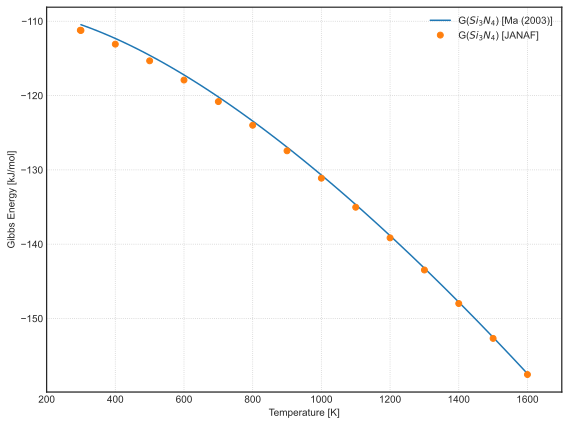

In [8]:
plt.close("all")
plt.style.use("seaborn-white")
plt.figure(figsize=(8, 6))
plt.plot(T_1, GSI3N4_1/1000, "-", label="G($Si_3N_4$) [Ma (2003)]")
plt.plot(T_2, GSI3N4_2/1000, "o", label="G($Si_3N_4$) [JANAF]")
plt.xlabel("Temperature [K]")
plt.ylabel("Gibbs Energy [kJ/mol]")
plt.xlim(200, 1700)
plt.grid(linestyle=":")
plt.legend(loc="best")
plt.tight_layout()

## Application to $MnSiN_2$

**WORK IN PROGRESS**

In [9]:
GHSERMN = np.piecewise(T, [T < 1519.0, T >= 1519.0], [
    lambda T: -8.115280e+03+1.300590e+02*T-2.34582e+01*T*np.log(T)\
        -7.347680e-03*T**2+6.98271e+04*T**(-1),
    lambda T: -2.873341e+04+3.122648e+02*T-4.80000e+01*T*np.log(T)\
        +1.6568470+30*T**(-9)
])

GHSERNN = np.piecewise(T, [T < 950.00, (950.00 <= T) & (T < 3350.00), T >= 3350.00], [
    lambda T: -3.750675e+03-9.45425e+00*T-1.27819e+01*T*np.log(T)\
        -1.76686e-03*T**2+2.680735e-09*T**3-3.237400e+04*T**(-1),
    lambda T: -7.358850e+03+1.72003e+01*T-1.63699e+01*T*np.log(T)\
        -6.51070e-04*T**2+3.009700e-08*T**3+5.630700e+05*T**(-1),
    lambda T: -1.639280e+04+5.02600e+01*T-2.04695e+01*T*np.log(T)\
        +2.39754e-04*T**2-8.333100e-09*T**3+4.596375e+06*T**(-1)
])

GHSERSI = np.piecewise(T, [T < 1687.0, T >= 1687.0], [
    lambda T: -8.162609e+03+1.37236859e+02*T-2.28317533e+01*T*np.log(T)\
        -1.912904e-03*T**2-3.552E-9*T**3+1.76667e+05*T**(-1),
    lambda T: -9.457642e+03+1.67281367e+02*T-2.71960000e+01*T*np.log(T)\
        -4.203700e+30*T**(-9)
])

# HSERMN = 4.995696E+03
# HSERSI = 4.335000E+03
# HSERNN = 3.217000E+03
# (0.25*HSERMN+0.25*HSERSI+0.5*HSERNN)
hypothesis_scale = 10

G_sum_xk_Gk = 0.25*GHSERMN+0.25*GHSERSI+0.5*GHSERNN
G_form_MNSIN2_MC = -86500.0+43.0*T
G_form_MNSIN2_LI = np.piecewise(T, [T < 980.0, T >= 980.0], [
    lambda T: -994489.0 + 454.0*T,
    lambda T: -970238.0 + 429.0*T
]) / hypothesis_scale

G_MNSIN2_MC = G_sum_xk_Gk + G_form_MNSIN2_MC
G_MNSIN2_LI = G_sum_xk_Gk + G_form_MNSIN2_LI

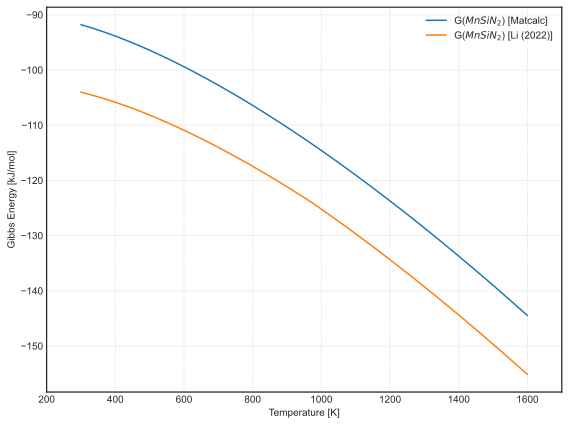

In [10]:
plt.close("all")
plt.style.use("seaborn-white")
plt.figure(figsize=(8, 6))
plt.plot(T, G_MNSIN2_MC/1000, "-", label="G($MnSiN_2$) [Matcalc]")
plt.plot(T, G_MNSIN2_LI/1000, "-", label="G($MnSiN_2$) [Li (2022)]")
plt.xlabel("Temperature [K]")
plt.ylabel("Gibbs Energy [kJ/mol]")
plt.xlim(200, 1700)
plt.grid(linestyle=":")
plt.legend(loc="best")
plt.tight_layout()